In [7]:
import argparse
import os
import copy
import sys
import time
from datetime import datetime
import torch
import random
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader

from utils import *
from deltamodel import VectorFieldOperation, DeltaModel
from weno import get_calculator, compute_residual
from PDEs import PDE, KdV, KS, Burgers

from torchdiffeq import odeint_adjoint as odeint

pde = 'KdV'
batch_size = 16
n_delta = 4
device = torch.device('cuda')

data_path = f'data/{pde}_train_1024_default.h5'
pde_path = f'data/{pde}_default.pkl'



with open(pde_path,'rb') as f:
    pde = pickle.load(f)
    
nt = pde.nt_effective
nx = pde.nx
dt = pde.dt
dx = pde.dx

train_dataset = HDF5Dataset(data_path,
                            mode='train',
                            nt=nt,
                            nx=nx,
                            n_data=1024,
                            pde=pde)
train_loader = DataLoader(train_dataset,
                            batch_size=batch_size,
                            shuffle=True,
                            num_workers=4,
                            persistent_workers=True,
                            pin_memory=True)



scale_dict = {
    'KdV':0.3463,
    'KS':0.2130,
    'Burgers':20.19,
    'nKdV':0.4345,
    'cKdV':3.6310,
}

u_scale = scale_dict[str(pde)]
u_scaler = ConstantScaler(u_scale)

vfop = VectorFieldOperation()
delta_model = DeltaModel(vfop,n_delta = n_delta).to(device)

exp_name = 'exp20241220180546'
delta_model.load_state_dict(torch.load(os.path.join(f'exp_{str(pde)}',exp_name,'deltamodel.pt')))

/tmp/ipykernel_24332/3586390493.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  delta_model.load_state_dict(torch.load(os.path.join(f'exp_{str(pde)}',exp_name,'deltamod

<All keys matched successfully>

In [8]:
if str(pde) in ['KdV','KS']:
    c1 = (dt * nt) / (dx * nx)
    c2 = u_scaler.c

    def lps_delta_func(xtu):
        x = xtu[:,0] # needs actual value for only the last delta
        t = xtu[:,1]
        u = xtu[:,2]

        ones = torch.ones_like(x)
        zeros = torch.zeros_like(x)
        xs = x
        ts = t
        us = u

        delta = torch.stack([
            torch.stack([ones,zeros,zeros],dim=1),
            torch.stack([zeros,ones,zeros],dim=1),
            torch.stack([c1*t,zeros,c2 * ones],dim=1),
        ],dim=2)
        delta = vfop.normalize_delta(delta)

        for i in range(delta.shape[-1]):
            for j in range(i):
                delta[...,i] = delta[...,i] - vfop.inner_product(delta[...,j],delta[...,i]) * delta[...,j]
                
                
        delta[...,-1] = vfop.normalize_delta(delta[...,-1] - vfop.inner_product(delta[...,0],delta[...,-1]) * delta[...,0])
        return delta

    n_lps = 3
    lps_names = [
        'x-tsl',
        't-tsl',
        'gal'
    ]
elif str(pde) == 'Burgers':

    c1 = (dt * nt) / (dx * nx)
    c2 = u_scaler.c

    def lps_delta_func(xtu):
        x = xtu[:,0] # needs actual value for only the last delta
        t = xtu[:,1]
        u = xtu[:,2]

        ones = torch.ones_like(x)
        zeros = torch.zeros_like(x)
        xs = x
        ts = t
        us = u

        delta = torch.stack([
            torch.stack([ones,zeros,zeros],dim=1),
            torch.stack([zeros,ones,zeros],dim=1),
            torch.stack([zeros,zeros,u],dim=1),
            torch.stack([c1*t,zeros,c2 * ones],dim=1),
        ],dim=2)
        delta = vfop.normalize_delta(delta)

        for i in range(delta.shape[-1]):
            for j in range(i):
                delta[...,i] = delta[...,i] - vfop.inner_product(delta[...,j],delta[...,i]) * delta[...,j]
        # delta[...,-1] = vfop.normalize_delta(delta[...,-1] - vfop.inner_product(delta[...,0],delta[...,-1]) * delta[...,0])
        # delta[...,-1] = vfop.normalize_delta(delta[...,-1] - vfop.inner_product(delta[...,2],delta[...,-1]) * delta[...,2])
        return delta

    n_lps = 4
    lps_names = [
        'x-tsl',
        't-tsl',
        'gal',
        'u-scl',
    ]
    
elif str(pde) == 'nKdV':

    c1 = (dt * nt) / (dx * nx)
    c2 = u_scaler.c
    def lps_delta_func(xtu):
        x = xtu[:,0] # needs actual value for only the last delta
        t = xtu[:,1]
        u = xtu[:,2]
        t = t * nt * dt + 100 / 249 * 110

        ones = torch.ones_like(x)
        zeros = torch.zeros_like(x)
        

        delta = torch.stack([
            torch.stack([ones,zeros,zeros],dim=1),
            torch.stack([zeros,1/torch.exp(t / 50),zeros],dim=1),
            torch.stack([50 * (torch.exp(t/50)-1) / (dx*nx),zeros,c2 * ones],dim=1),
        ],dim=2)
        delta = vfop.normalize_delta(delta)

        
        # delta[...,-1] = vfop.normalize_delta(delta[...,-1] - vfop.inner_product(delta[...,0],delta[...,-1]) * delta[...,0])
        for i in range(delta.shape[-1]):
            for j in range(i):
                delta[...,i] = delta[...,i] - vfop.inner_product(delta[...,j],delta[...,i]) * delta[...,j]
            delta[...,i] = vfop.normalize_delta(delta[...,i])
        return delta

    delta_lps = lps_delta_func(xtu)
    n_lps = delta_lps.shape[-1]
    lps_names = [
        'x-tsl',
        '$g_2$',
        '$g_3$'
    ]
elif str(pde) == 'cKdV':

    c1 = (dt * nt) / (dx * nx)
    c2 = u_scaler.c
    def lps_delta_func(xtu):
        x = xtu[:,0] # needs actual value for only the last delta
        t = xtu[:,1]
        u = xtu[:,2]
        x = x * nx * dt
        t = t * nt * dt + 100 / 249 * 110
        u = u_scaler.inv_scale(u)

        ones = torch.ones_like(x)
        zeros = torch.zeros_like(x)
        

        delta = torch.stack([
            torch.stack([ones,zeros,zeros],dim=1),
            torch.stack([((t+1)**0.5) / (dx * nx),zeros ,1 / (2 * ((t+1) ** 0.5)) * c2],dim=1),
            torch.stack([zeros,ones,zeros],dim=1),
            # torch.stack([x / (dx * nx),3 * t / (dt * nt),-2 * u * c2 ],dim=1),
            # torch.stack([x * (t**0.5)/(dx*nx),2 * (t ** 1.5) / (dt * nt), 0.5 *(x/(t**0.5) - 4 * u * (t**0.5))*0.5 ],dim=1),
        ],dim=2)
        delta = vfop.normalize_delta(delta)

        
        for i in range(delta.shape[-1]):
            for j in range(i):
                delta[...,i] = delta[...,i] - vfop.inner_product(delta[...,j],delta[...,i]) * delta[...,j]
            delta[...,i] = vfop.normalize_delta(delta[...,i])
        # delta[...,-1] = vfop.normalize_delta(delta[...,-1] - vfop.inner_product(delta[...,0],delta[...,-1]) * delta[...,0])
        return delta

    delta_lps = lps_delta_func(xtu)
    n_lps = delta_lps.shape[-1]
    lps_names = [
        'x-tsl',
        '$g_2$',
        't-tsl',
        # 'v4',
    ]

0it [00:00, ?it/s]


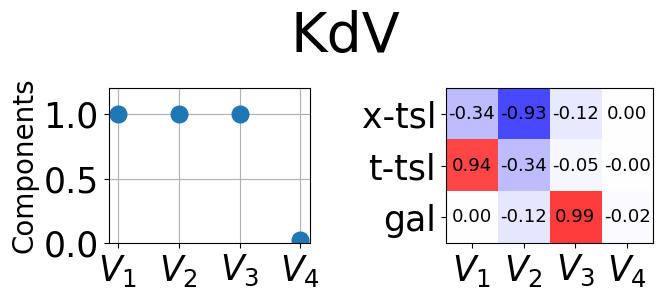

In [11]:
with torch.no_grad():
    for batch_idx,(u,) in tqdm(enumerate(train_loader)):
        u = u.to(device)

        
        batch_size,_,_ = u.shape
        
        x = torch.arange(nx).to(device,torch.float32)/nx
        t = torch.arange(nt).to(device,torch.float32)/nt
        u = u_scaler.scale(u)
        xtu = torch.stack([x[None,None,:].repeat(batch_size,nt,1),
                    t[None,:,None].repeat(batch_size,1,nx),
                    u
                    ],dim=3)
        
        xtu = xtu.flatten(0,2)
        idx = torch.rand(size=(xtu.shape[0],),device=xtu.device)<0.01
        xtu = xtu[idx]
        # xtu = xtu[...,None].repeat(1,1,n_delta)
        delta = delta_model(xtu)
        break

delta_lps = lps_delta_func(xtu)

lps_component = vfop.inner_product(delta,delta_lps).detach().cpu()

fig,axes = plt.subplots(ncols=2,figsize=(7,3),gridspec_kw={'width_ratios': [1, 1.3]})
# plt.figure(figsize=(5,3))
plt.sca(axes[0])
plt.plot((lps_component**2).sum(dim=1)**0.5,'o',markersize=12)
plt.ylim(0,1.2)
# plt.title(exp_name)
plt.xticks(range(n_delta),[f'$V_{{{i+1}}}$' for i in range(n_delta)],fontsize=25)
plt.yticks([0,0.5,1],fontsize=25)

plt.ylabel('Components',fontsize=20)

# plt.title(str(pde),fontsize=20)

plt.grid()
# plt.show()
# plt.close()
# plt.figure(figsize=(4,7))
plt.sca(axes[1])
aspect = 1 if n_lps==3 else 0.75
plt.imshow(lps_component.T,cmap = 'bwr', vmax = 1.3, vmin = -1.3,aspect = aspect)
for i in range(n_delta):
    for j in range(n_lps):
        plt.text(i,j,'{:.2f}'.format(lps_component[i,j]),ha='center', va='center',fontsize=13)
plt.yticks(range(n_lps),lps_names,fontsize=25)
plt.xticks(range(n_delta),[f'$V_{{{i+1}}}$' for i in range(n_delta)],fontsize=25)
# plt.title(str(pde),fontsize=20)
fig.suptitle(str(pde),fontsize=40)
fig.tight_layout()
plt.show(fig)
plt.close(fig)